### Pendulum: One-step Method + L-BFGS

In [1]:
import sys
#sys.path.append('/home/juanfelipe/Desktop/research/keql/source')
sys.path.append('/Users/yasaminjalalian/Repos/keql/source')

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize

from functools import partial # for jit to make codes faster

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from jax.config import config; 
config.update("jax_enable_x64", True)

In [4]:
model = 'pendulum'

In [5]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

In [6]:
two_step_dict

{'optim_sgm_u': array([0.14840741, 0.88888889, 0.88888889]),
 'optim_nugget_u': array([1.e-14, 1.e-08, 1.e-14]),
 'rkhs_u': [1.1833129901359858, 10.115344144667745, 136.21275744971464],
 'optim_sgm_P': 0.8152750039562016,
 'optim_nugget_P': 1e-08,
 'nugget_P': 1e-07,
 'rkhs_P': 4038.900702619145,
 'f_pred_test': array([  4.52012592,   6.21651415,   7.78734153,   0.0677476 ,
        -13.1670231 , -10.84996918,  10.14056579,  38.04548527,
         24.77680788,   4.03514364,   2.39721262,   2.15514416,
          2.18068307,   2.53098877,   3.19260485,   4.06413591,
          4.96255826,   5.66164536,   5.95623916,   5.73084622,
          3.45693687,   3.49929028,   3.9472561 ,   4.93767004,
          6.38396929,   7.94897049,   9.13204699,   9.36459357,
          8.12846995,   5.23276092])}

### Cost function

Compute `Kphiphi` and its corresponding regularizing matrix `R`

In [7]:
# Create Kphiphi
X = x_train.flatten()
sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
Kphiphis = [Kphiphi_assembly( X[i*N_train:(i+1)*N_train] , k = 'Gaussian', k_param = sigma_K[i]) for i in range(3)]

In [8]:
Rs = [jnp.diag(jnp.diag(Kphiphis[i])) for i in range(3)]

Create objective function `L`

In [9]:
def L(Z, X, U, f, Kphiphis, Rs, two_step_dict, lmbd):
    """Cost function for 1-step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrices that regularizes each Kphiphi.
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function. 
    Returns:
        scalar: a cost of this solution.    
    """ 
    # Re-shape Z into a matrix
    Z = Z.reshape(2,9).T

    ### First term

    # Build S_N
    S1 = jnp.vstack([X,U]).T
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    
    # Gamma(S_N,S_N) 
    optim_sgm_P = two_step_dict.get('optim_sgm_P')
    Gamma = K(Gaussian, S, S, optim_sgm_P)
    nugget_P = two_step_dict.get('nugget_P')
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma)) # Condition number of Gamma

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P')
    #print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    alpha_K = 1e-6 # Nugget 
    Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(3)] 
    #print("cond(Kphiphis) = ", jnp.linalg.cond(Kphiphis)) # Condition number

    ZZ = jnp.hstack((U.reshape(-1,1),Z))
    for i in range(3):
        Z_i = jnp.reshape(ZZ[N_train*i:N_train*(i+1),:].T,(N_train*3,1)) 
        #print('Z_{}'.format(i),Z_i) 
        c = jnp.linalg.solve(Kphiphis[i],Z_i) 
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),())/ two_step_dict.get('rkhs_u')[i] # NORMALIZATION MIGHT NOT BE NEEDED HERE IN THE 1.5 STEP METHOD
        print("L2_{} = ".format(i+1),jnp.reshape(jnp.dot(Z_i.T , c),()) / two_step_dict.get('rkhs_u')[i])
    # Compute the total loss per epoch - It's going down !
    # Compute the loss per function u epoch  
    # Compute the total loss normalized per epoch
    # Compute the loss per function u normalized per epoch

    #print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

#### Training data and warm up

Training data

In [10]:
# First column in Gamma(S_N,S_N)
X = x_train.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.T.reshape(N_train*m,) # N*m * 1

# f(X_N)
f = f_Train(model)

Initial guess: `Z_warm`

In [11]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = np.hstack([u_x_pred_train.T.reshape(N_train*m,1),u_xx_pred_train.T.reshape(N_train*m,1)])
Z_warm = Z_warm.T.flatten()

In [12]:
L(Z_warm, X, U, f, Kphiphis, Rs, two_step_dict, lmbd = 1/3)

L2_1 =  0.9999987557852718
L2_2 =  0.9999983273696618
L2_3 =  0.9999990722837172


DeviceArray(1.99999896, dtype=float64)

In [13]:
two_step_dict.get('rkhs_u')[1]

10.115344144667745

In [14]:
lmbd_min = 1/3 

#### LBFGS

In [15]:
# Load the warm-up
Z = np.copy(Z_warm)

In [16]:
result = minimize(L, Z, args=(X, U, f, Kphiphis, Rs, two_step_dict, 1/3), method= 'BFGS')

L2_1 =  Traced<ConcreteArray(0.9999987557852718, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.99999876, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fc79f6c6a50>, invars=(Traced<ConcreteArray(1.1833129901359858, dtype=float64):JaxprTrace(level=1/0)>, Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fc7a1321d10; to 'JaxprTracer' at 0x7fc7a1321c50>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = div b a in (c,) }}, source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fc7a07daeb0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
L2_2 =  Traced<ConcreteArray(0.9999983273696618, dtype=float64)>with<JVPTrace(level=2/0)> w

In [17]:
Z = result.x.reshape(2,9).T

#### Evaluation of `Z`

In [18]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(N_train*m,1),u_xx_train.T.reshape(N_train*m,1)])

> One-step Method vs Truth

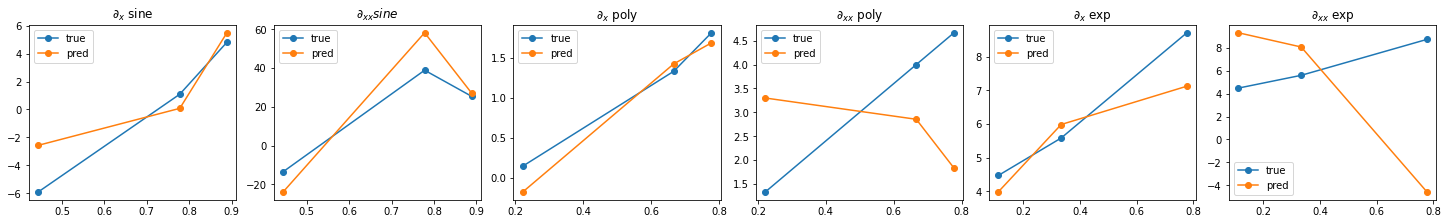

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:N_train],Z_true[0:N_train,0],label ='true', marker= 'o')
ax1.plot(x_train[0:N_train],Z[0:N_train,0],label ='pred', marker= 'o')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:N_train],Z_true[0:N_train,1],label ='true', marker= 'o')
ax2.plot(x_train[0:N_train],Z[0:N_train,1],label ='pred', marker= 'o')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[N_train:2*N_train],Z_true[N_train:2*N_train,0],label ='true', marker= 'o')
ax3.plot(x_train[N_train:2*N_train],Z[N_train:2*N_train,0],label ='pred', marker= 'o')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[N_train:2*N_train],Z_true[N_train:2*N_train,1],label ='true', marker= 'o')
ax4.plot(x_train[N_train:2*N_train],Z[N_train:2*N_train,1],label ='pred', marker= 'o')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*N_train:3*N_train],Z_true[2*N_train:3*N_train,0],label ='true', marker= 'o')
ax5.plot(x_train[2*N_train:3*N_train],Z[2*N_train:3*N_train,0],label ='pred', marker= 'o')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*N_train:3*N_train],Z_true[2*N_train:3*N_train,1],label ='true', marker= 'o')
ax6.plot(x_train[2*N_train:3*N_train],Z[2*N_train:3*N_train,1],label ='pred', marker= 'o')
ax6.legend()
plt.show()

> Two-step Method vs Truth

In [20]:
Z_warm = Z_warm.reshape(2,9).T

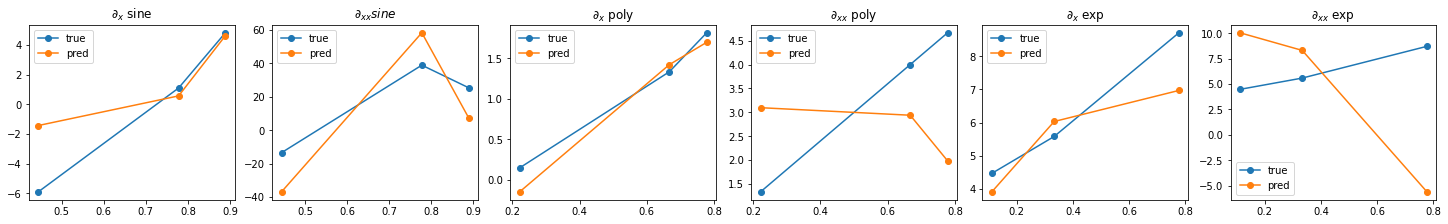

In [21]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:N_train],Z_true[0:N_train,0],label ='true', marker= 'o')
ax1.plot(x_train[0:N_train],Z_warm[0:N_train,0],label ='pred', marker= 'o')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:N_train],Z_true[0:N_train,1],label ='true', marker= 'o')
ax2.plot(x_train[0:N_train],Z_warm[0:N_train,1],label ='pred', marker= 'o')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[N_train:2*N_train],Z_true[N_train:2*N_train,0],label ='true', marker= 'o')
ax3.plot(x_train[N_train:2*N_train],Z_warm[N_train:2*N_train,0],label ='pred', marker= 'o')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[N_train:2*N_train],Z_true[N_train:2*N_train,1],label ='true', marker= 'o')
ax4.plot(x_train[N_train:2*N_train],Z_warm[N_train:2*N_train,1],label ='pred', marker= 'o')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*N_train:3*N_train],Z_true[2*N_train:3*N_train,0],label ='true', marker= 'o')
ax5.plot(x_train[2*N_train:3*N_train],Z_warm[2*N_train:3*N_train,0],label ='pred', marker= 'o')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*N_train:3*N_train],Z_true[2*N_train:3*N_train,1],label ='true', marker= 'o')
ax6.plot(x_train[2*N_train:3*N_train],Z_warm[2*N_train:3*N_train,1],label ='pred', marker= 'o')
ax6.legend()
plt.show()

#### Predictions of P

Recall on the Representer formula

$$
P^*(\cdot) = \Gamma(\cdot,S_N) \Gamma(S_N,S_N)^{-1} f(X_N)
$$

In [22]:
# Build S_N - Training data
S1 = jnp.vstack([X,U]).T
S = jnp.hstack([S1,Z])
# Load gradients from 2-step
u_x_pred_test  = np.load('data/u_x_pred_test.npy')
u_xx_pred_test = np.load('data/u_xx_pred_test.npy')
s_test = np.hstack((x_test.reshape(-1,1),u_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1)))  # 30 * 4
f_train = f_Train(model)
f_test = f_Test(model)
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(S)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_train)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)

> fig.suptitle('1-step method')

/Users/yasaminjalalian/opt/anaconda3/envs/CG/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


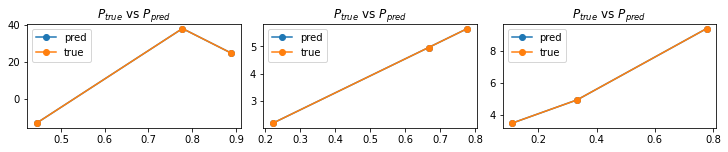

In [23]:
# Plot at training points
fig, axs = plt.subplots(nrows = 1, ncols=3 , figsize = (10, 2),constrained_layout=True)
axs[0].plot(x_train[:N_train], f_pred_train[:N_train], marker= 'o', label = 'pred')
axs[0].plot(x_train[:N_train], f_train[:N_train] , marker= 'o', label = 'true')
axs[0].legend()
axs[0].set_title('$P_{true}$ vs $P_{pred}$')
axs[1].plot(x_train[N_train:2*N_train], f_pred_train[N_train:2*N_train],marker= 'o', label = 'pred')
axs[1].plot(x_train[N_train:2*N_train], f_train[N_train:2*N_train],marker= 'o', label = 'true')
axs[1].legend()
axs[1].set_title('$P_{true}$ vs $P_{pred}$')
axs[2].plot(x_train[2*N_train:3*N_train], f_pred_train[2*N_train:3*N_train],marker= 'o', label = 'pred')
axs[2].plot(x_train[2*N_train:3*N_train], f_train[2*N_train:3*N_train],marker= 'o', label = 'true')
axs[2].legend()
axs[2].set_title('$P_{true}$ vs $P_{pred}$')
fig.show()

> fig.suptitle('1-step method')

/Users/yasaminjalalian/opt/anaconda3/envs/CG/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


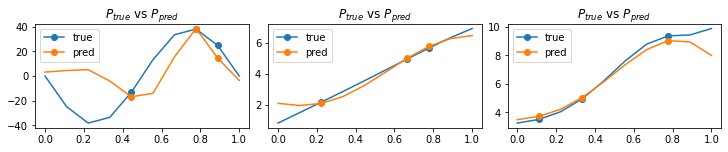

In [25]:
# Plot at testing points
fig, axs = plt.subplots(nrows = 1, ncols=3 , figsize = (10, 2),constrained_layout=True)

axs[0].plot(x_test[:N_test], f_test[:N_test],      marker= 'o', markevery = idx[0], label = 'true')
axs[0].plot(x_test[:N_test], f_pred_test[:N_test], marker= 'o', markevery = idx[0], label = 'pred')
axs[0].legend()
axs[0].set_title('$P_{true}$ vs $P_{pred}$')

axs[1].plot(x_test[N_test:2*N_test], f_test[N_test:2*N_test],      marker= 'o',markevery = idx[1], label = 'true')
axs[1].plot(x_test[N_test:2*N_test], f_pred_test[N_test:2*N_test], marker= 'o',markevery = idx[1], label = 'pred')
axs[1].legend()
axs[1].set_title('$P_{true}$ vs $P_{pred}$')

axs[2].plot(x_test[2*N_test:3*N_test], f_test[2*N_test:3*N_test],      marker= 'o', markevery = idx[2], label = 'true')
axs[2].plot(x_test[2*N_test:3*N_test], f_pred_test[2*N_test:3*N_test], marker= 'o', markevery = idx[2], label = 'pred')
axs[2].legend()
axs[2].set_title('$P_{true}$ vs $P_{pred}$')
fig.show()